In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q albumentations
!pip install -q pycocotools
!pip install pycocotools


In [ ]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from albumentations import Compose, Resize, Normalize
from albumentations.pytorch import ToTensorV2
import torch
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F




In [ ]:
class RoadsideObjectDetectionDataset(Dataset):
    def __init__(self, img_dir, ann_dir, transforms=None):
        self.img_paths = sorted(glob(os.path.join(img_dir, "*.jpg")))
        self.ann_paths = sorted(glob(os.path.join(ann_dir, "*.json")))
        self.transforms = transforms
        self.class_map = {"car": 1, "pedestrian": 2}  # background is 0

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        ann_path = self.ann_paths[idx]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = F.to_tensor(img)

        with open(ann_path) as f:
            data = json.load(f)

        boxes = []
        labels = []

        for obj in data['objects']:
            label = self.class_map.get(obj['classTitle'], 0)
            if obj['geometryType'] == "rectangle":
                (x1, y1), (x2, y2) = obj['points']['exterior']
                if x1 != x2 and y1 != y2:  # Filter invalid boxes
                    boxes.append([x1, y1, x2, y2])
                    labels.append(label)

        if len(boxes) == 0:  # Skip samples with no valid boxes
            return self.__getitem__((idx + 1) % len(self))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
        }

        return img, target


In [ ]:
transform = Compose([
    Resize(224, 224),
    Normalize(),
    ToTensorV2()
])


In [ ]:
train_dataset = RoadsideObjectDetectionDataset(
    img_dir='/content/drive/MyDrive/roadSide_dataset/data/train/img',
    ann_dir='/content/drive/MyDrive/roadSide_dataset/data/train/ann'
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))



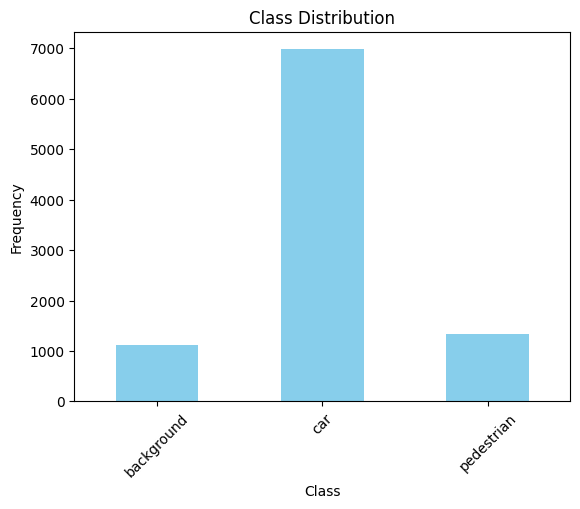

In [ ]:
import pandas as pd
from collections import Counter

# Predefined list of all class names
class_names = ["background", "car", "pedestrian", "other"]  # Modify as needed

# Initialize Counter to keep track of class occurrences
label_counts = Counter()

# Iterate through the dataset and count occurrences of each class
for _, target in train_dataset:
    labels = target['labels']
    label_counts.update(labels.cpu().numpy())  # Make sure labels are on CPU and count them

# Convert label counts to a pandas Series for better plotting
label_counts_series = pd.Series(label_counts).sort_index()

# Plot the class distribution with class names on the x-axis
ax = label_counts_series.plot(kind='bar', color='skyblue')

# Set x-axis labels to class names
ax.set_xticklabels([class_names[i] for i in label_counts_series.index])

plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier head with your number of classes (2 + background = 3)
num_classes = 3
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 78.6MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in tqdm(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")


100%|██████████| 340/340 [03:19<00:00,  1.71it/s]


Epoch 1, Loss: 323.1307


100%|██████████| 340/340 [03:19<00:00,  1.70it/s]


Epoch 2, Loss: 265.3428


100%|██████████| 340/340 [03:20<00:00,  1.70it/s]


Epoch 3, Loss: 234.6043


100%|██████████| 340/340 [03:20<00:00,  1.70it/s]


Epoch 4, Loss: 213.3456


100%|██████████| 340/340 [03:20<00:00,  1.70it/s]

Epoch 5, Loss: 196.4953


In [ ]:
model.eval()  # Set the model to evaluation mode

# Path to save the model in your Google Drive
save_path = "/content/drive/MyDrive/roadSide_dataset/new_saved_model.pth"

# Save the model's state_dict (weights) to the specified path
torch.save(model.state_dict(), save_path)

print(f"Model saved to {save_path}")


Model saved to /content/drive/MyDrive/roadSide_dataset/new_saved_model.pth


Testing Progress:   0%|          | 0/86 [00:00<?, ?it/s]

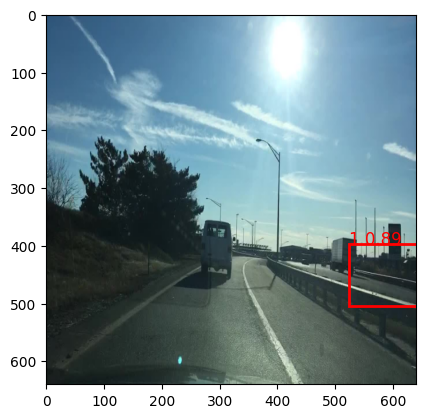

Testing Progress:   1%|          | 1/86 [00:00<00:33,  2.51it/s]

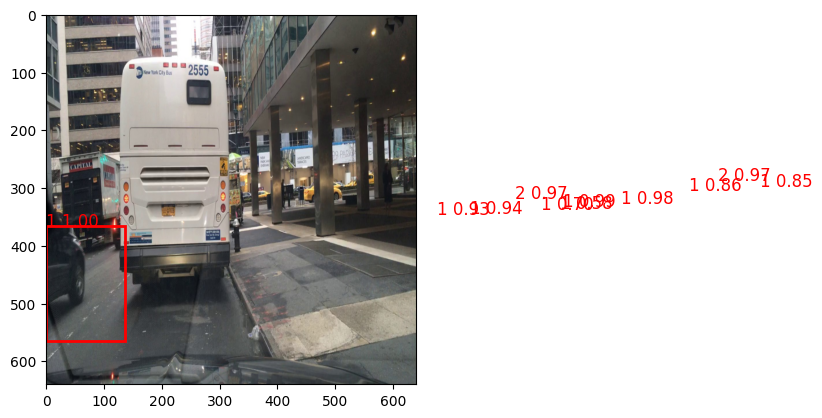

Testing Progress:   2%|▏         | 2/86 [00:00<00:41,  2.02it/s]

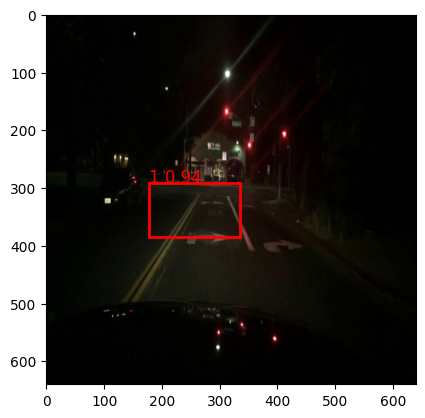

Testing Progress:   3%|▎         | 3/86 [00:01<00:38,  2.14it/s]

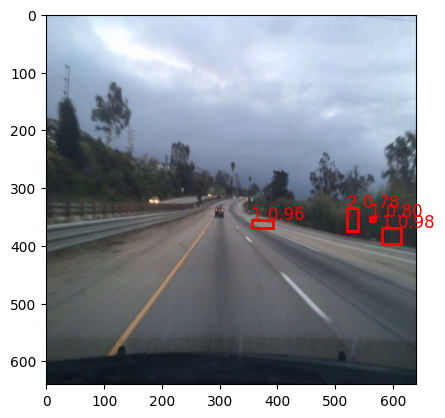

Testing Progress:   5%|▍         | 4/86 [00:01<00:38,  2.11it/s]

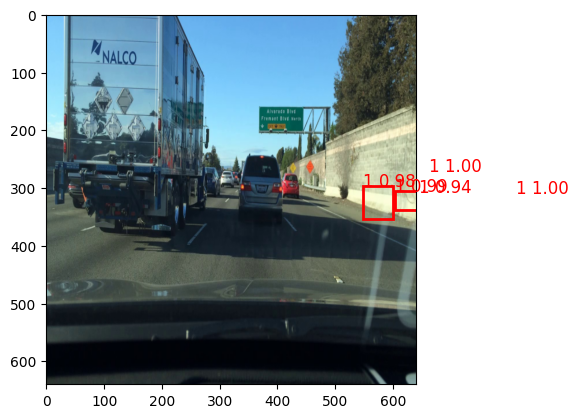

Testing Progress: 100%|██████████| 86/86 [00:19<00:00,  4.43it/s]


Average Precision: 0.0771
Average Recall: 0.0799
Average F1 Score: 0.0779
Average Accuracy: 0.6369


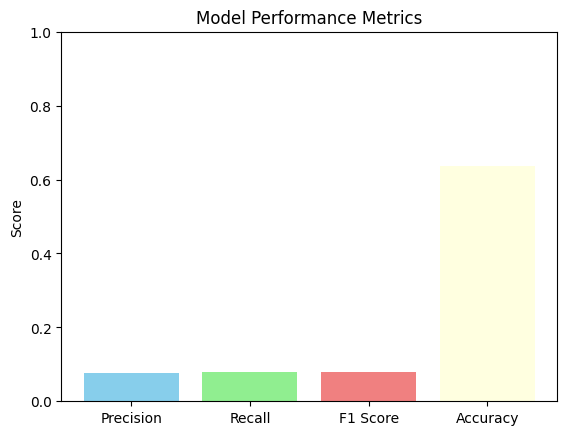

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from collections import defaultdict

# Function to calculate precision, recall, F1 score, and accuracy
def compute_metrics(predictions, targets, threshold=0.5):
    true_labels = []
    pred_labels = []
    correct_detections = 0
    total_detections = 0
    total_gt_boxes = 0

    def calculate_iou(box1, box2):
        # Calculate intersection over union (IoU)
        x1, y1, x2, y2 = box1
        x1_2, y1_2, x2_2, y2_2 = box2
        inter_x1 = max(x1, x1_2)
        inter_y1 = max(y1, y1_2)
        inter_x2 = min(x2, x2_2)
        inter_y2 = min(y2, y2_2)

        inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
        box1_area = (x2 - x1) * (y2 - y1)
        box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)

        iou = inter_area / (box1_area + box2_area - inter_area)
        return iou

    for i in range(len(predictions)):
        boxes = predictions[i]['boxes']
        labels = predictions[i]['labels']
        scores = predictions[i]['scores']

        # Get ground truth boxes and labels
        target = targets[i]
        target_boxes = target['boxes']
        target_labels = target['labels']

        # Filter predictions by threshold
        valid_preds = [(label.item(), score, box) for label, score, box in zip(labels, scores, boxes) if score > threshold]

        # Collect predictions and ground truth
        for label, _, box in valid_preds:
            pred_labels.append(label)

        for label in target_labels:
            true_labels.append(label.item())

        # Calculate accuracy using IoU for bounding boxes
        for pred_box in valid_preds:
            pred_label = pred_box[0]
            pred_bbox = pred_box[2]

            for true_box in target_boxes:
                iou = calculate_iou(pred_bbox, true_box)
                if iou > 0.5:  # If IoU is greater than 0.5, it's a correct detection
                    correct_detections += 1
                    total_detections += 1
                    break

        total_gt_boxes += len(target_boxes)

    # Ensure consistency of lengths for precision, recall, and F1 score
    if len(true_labels) == len(pred_labels):
        # Calculate precision, recall, and F1 score (considering multiple classes)
        precision = precision_score(true_labels, pred_labels, average='macro', zero_division=0)
        recall = recall_score(true_labels, pred_labels, average='macro', zero_division=0)
        f1 = f1_score(true_labels, pred_labels, average='macro', zero_division=0)
    else:
        # Handle the case where the lengths don't match
        precision, recall, f1 = 0, 0, 0

    # Calculate accuracy (IoU > 0.5)
    accuracy = correct_detections / total_gt_boxes if total_gt_boxes > 0 else 0

    return precision, recall, f1, accuracy

# Perform Inference with Metrics Calculation
def test_model_with_metrics(model, test_loader, device, max_images=5, threshold=0.5):
    model.to(device)
    model.eval()

    precision_all, recall_all, f1_all, accuracy_all = [], [], [], []
    image_count = 0

    # Iterate over the test set
    for images, targets in tqdm(test_loader, desc="Testing Progress", total=len(test_loader)):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Perform inference with no gradient computation
        with torch.no_grad():
            prediction = model(images)

        # Calculate the metrics for each image
        precision, recall, f1, accuracy = compute_metrics(prediction, targets, threshold)
        precision_all.append(precision)
        recall_all.append(recall)
        f1_all.append(f1)
        accuracy_all.append(accuracy)

        # Visualization of predictions (only for a small number of images)
        if image_count < max_images:
            img = images[0].permute(1, 2, 0).cpu().numpy()  # Convert image from tensor to numpy
            img_resized = cv2.resize(img, (640, 640))

            # Show image with bounding boxes
            boxes = prediction[0]['boxes']
            labels = prediction[0]['labels']
            scores = prediction[0]['scores']

            valid_predictions = [(box, label, score) for box, label, score in zip(boxes, labels, scores) if score > threshold]
            plt.imshow(img_resized)
            for box, label, score in valid_predictions:
                x1, y1, x2, y2 = box.cpu().numpy()
                plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none'))
                plt.text(x1, y1, f'{label.item()} {score:.2f}', fontsize=12, color='red')
            plt.show()

            image_count += 1

        # Clear GPU memory after each batch to avoid crashes
        torch.cuda.empty_cache()

    # Calculate average precision, recall, F1 score, and accuracy over all images
    avg_precision = np.mean(precision_all)
    avg_recall = np.mean(recall_all)
    avg_f1 = np.mean(f1_all)
    avg_accuracy = np.mean(accuracy_all)

    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    print(f"Average Accuracy: {avg_accuracy:.4f}")

    return avg_precision, avg_recall, avg_f1, avg_accuracy

# Test Dataset
test_dataset = RoadsideObjectDetectionDataset(
    img_dir='/content/drive/MyDrive/roadSide_dataset/data/val/img',
    ann_dir='/content/drive/MyDrive/roadSide_dataset/data/val/ann'
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Run the model with metrics calculation
avg_precision, avg_recall, avg_f1, avg_accuracy = test_model_with_metrics(model, test_loader, device, max_images=5, threshold=0.5)

# Plot the performance metrics as a bar chart
metrics = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
scores = [avg_precision, avg_recall, avg_f1, avg_accuracy]

plt.bar(metrics, scores, color=['skyblue', 'lightgreen', 'lightcoral', 'lightyellow'])
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim([0, 1])  # Scores range from 0 to 1
plt.show()


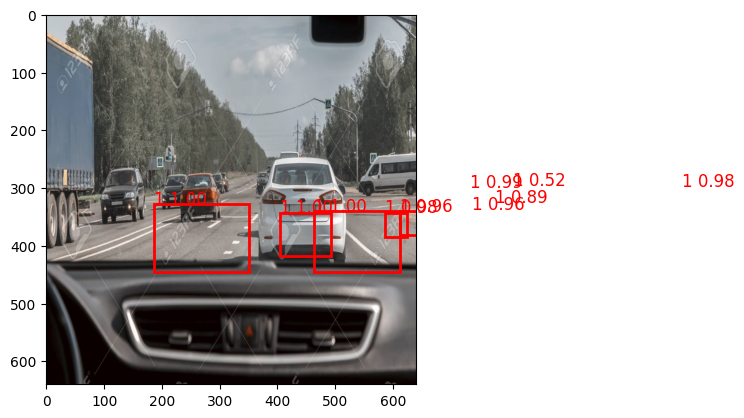

In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Step 1: Load the pre-trained Faster R-CNN model (without the final classifier)
model = fasterrcnn_resnet50_fpn(pretrained=False)

# Step 2: Modify the box predictor to match the number of classes in your dataset
num_classes = 3  # 3 classes: background + car + pedestrian

# The model was originally trained with 91 classes (including background). We replace the head.
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Step 3: Load the model's state_dict (weights) from your saved file
save_path = "/content/drive/MyDrive/roadSide_dataset/new_saved_model.pth"
model.load_state_dict(torch.load(save_path))

# Step 4: Set the model to evaluation mode
model.eval()  # Set the model to evaluation mode

# Step 5: Load the uploaded image from Colab content directory
image_path = "/content/car_2.jpg"  # Image uploaded to /content/ in Google Colab

# Open the image
img = Image.open(image_path)

# Step 6: Preprocess the image
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

# Step 7: Perform inference on the image
with torch.no_grad():
    prediction = model(img_tensor)

# Step 8: Visualize the results
boxes = prediction[0]['boxes']
labels = prediction[0]['labels']
scores = prediction[0]['scores']

# Convert image to numpy format for display
img_resized = np.array(img.resize((640, 640)))

# Visualize the image with bounding boxes (only for high score detections)
plt.imshow(img_resized)
for box, label, score in zip(boxes, labels, scores):
    if score > 0.5:  # You can adjust this threshold
        x1, y1, x2, y2 = box.cpu().numpy()
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none'))
        plt.text(x1, y1, f'{label.item()} {score:.2f}', fontsize=12, color='red')

plt.show()
